# Модель для расчета xG

Будем решать задачу бинарной классификации. В качестве xG получим вероятность принадлежности события к классу 1 (забит гол).

In [36]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Библиотека imblearn для работы с несбалансированными данными
from imblearn.over_sampling import SMOTE




## Анализ и предобработка данных

Считаем данные в pandas dataframe и посмотрим на них и их форму

In [2]:
raw_data = pd.read_csv('shots.csv')

In [3]:
raw_data.shape

(14410, 11)

In [4]:
raw_data.head(10)

,event,is_goal,period,time,distance,angle,is_rebound,is_pass_before,is_cross_line,is_one_touch,is_fast_attack
0,Shot Attempt - Wide left,False,1,1071.6,17.4,44.492971,False,False,False,False,False
1,Shot Attempt - Blocked,False,1,519.2,12.9,46.694647,False,False,False,False,False
2,Shot Attempt - Deflected,False,2,742.9,20.6,59.284706,False,False,False,False,False
3,Shot Attempt - Blocked,False,1,210.1,16.6,5.419532,False,True,False,True,False
4,Shot Attempt - Deflected,False,2,599.1,20.1,64.221569,False,False,False,False,False
5,Shot Attempt - Blocked,False,3,313.4,7.6,0.671568,False,False,False,False,False
6,Shot Attempt - Blocked,False,1,473.4,23.7,54.610680,False,False,False,False,False
7,Shot Attempt - Wide right,False,3,157.0,14.3,58.172553,False,True,False,True,False
8,Shot Attempt - Blocked,False,1,69.7,20.7,63.690162,False,False,False,False,False
9,Shot Attempt - Lower right,True,1,879.5,3.6,32.195734,False,False,True,False,False


Проверим, нет ли пропущенных данных

In [30]:
raw_data.isnull().values.any()

False

Посмотрим на таблицу корреляции

In [31]:
raw_data.corr()

,is_goal,period,time,distance,angle,is_rebound,is_pass_before,is_cross_line,is_one_touch,is_fast_attack
is_goal,1.000000,0.005795,0.004147,-0.162372,-0.006920,0.134554,0.038783,0.063968,0.104040,-0.030788
period,0.005795,1.000000,-0.019372,0.036188,0.000494,-0.006507,0.002162,0.002583,0.008407,-0.005033
time,0.004147,-0.019372,1.000000,-0.030159,-0.010308,0.014880,0.014812,0.015033,0.018167,-0.016269
distance,-0.162372,0.036188,-0.030159,1.000000,0.261968,-0.275493,-0.013634,-0.123294,-0.167065,0.082289
angle,-0.006920,0.000494,-0.010308,0.261968,1.000000,-0.046842,0.108705,0.118778,0.080740,0.038751
is_rebound,0.134554,-0.006507,0.014880,-0.275493,-0.046842,1.000000,-0.085215,0.065985,0.322959,-0.093079
is_pass_before,0.038783,0.002162,0.014812,-0.013634,0.108705,-0.085215,1.000000,0.291032,0.754175,-0.138111
is_cross_line,0.063968,0.002583,0.015033,-0.123294,0.118778,0.065985,0.291032,1.000000,0.293534,0.027301
is_one_touch,0.104040,0.008407,0.018167,-0.167065,0.080740,0.322959,0.754175,0.293534,1.000000,-0.188334
is_fast_attack,-0.030788,-0.005033,-0.016269,0.082289,0.038751,-0.093079,-0.138111,0.027301,-0.188334,1.000000


Видно, что все признаци довольно слабо коррелируют с целевым показателем 

In [34]:
y = raw_data.is_goal
data = raw_data.drop(['event','is_goal'], axis = 1)

Отобразим данные в двумерное пространство и визуализируем их

In [35]:
#функция для построения графика

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

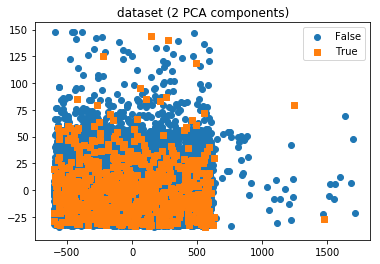

In [37]:
pca = PCA(n_components=2)
X = pca.fit_transform(data)

plot_2d_space(X, y, 'dataset (2 PCA components)')

Визуализируем распределение классов

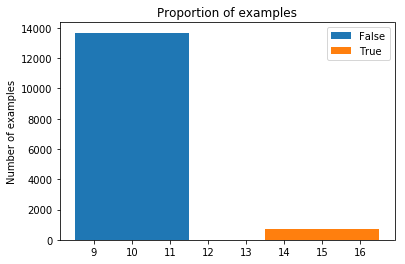

In [38]:
first_len = raw_data[raw_data['is_goal'] == False].shape[0]
second_len = raw_data[raw_data['is_goal'] == True].shape[0]

plt.bar(10,first_len,3, label="False")
plt.bar(15,second_len,3, label="True")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

Видно, что датасет несбалансирован. Применим over-sampling.

In [39]:
y = y.apply(lambda x: int(x))
data.loc[:, 'is_rebound':] = data.loc[:,'is_rebound':].apply(lambda x: [int(y) for y in x])

In [40]:
#Используем SMOTE over-sampling из библиотеки imblearn
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(data, y)

Разделим данные на обучающие и тестовые

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.10, random_state=42)

Из анализа данных видно, что линейные модели не смогут показать хороший результат. Попробуем исползовать градиентный бустинг.

## Обучение модели

Будем подбирать параметры с помощью GridSearch с кросс валидацией на 5 фолдов.

In [14]:
parameters = {
    'nthread': [16],
    'objective': ['binary:logistic'],
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01],
    'n_estimators': [250, 500, 1000, 2000],
    'seed': [42]
}

classifier = XGBClassifier()
classifier = GridSearchCV(classifier, parameters,cv=5, scoring='neg_log_loss', verbose=2)
classifier.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] learning_rate=0.01, max_depth=4, n_estimators=250, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=250, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=   2.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=250, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=4, n_estimators=250, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=   1.8s
[CV] learning_rate=0.01, max_depth=4, n_estimators=250, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=250, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=   1.8s
[CV] learning_rate=0.01, max_depth=4, n_estimators=250, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=250, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=   1.6s
[CV] learning_rate=0.01, max_depth=4, n_estimators=250, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=250, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=   1.8s
[CV] learning_rate=0.01, max_depth=4, n_estimators=500, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=

[CV]  learning_rate=0.01, max_depth=5, n_estimators=2000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=  16.7s
[CV] learning_rate=0.01, max_depth=5, n_estimators=2000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=5, n_estimators=2000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=  16.9s
[CV] learning_rate=0.01, max_depth=5, n_estimators=2000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=5, n_estimators=2000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=  17.1s
[CV] learning_rate=0.01, max_depth=5, n_estimators=2000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=5, n_estimators=2000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=  17.4s
[CV] learning_rate=0.01, max_depth=5, n_estimators=2000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learni

[CV]  learning_rate=0.01, max_depth=7, n_estimators=500, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=   6.0s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=  11.4s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=  11.6s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learning_rate=0.01, max_depth=7, n_estimators=1000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42, total=  11.5s
[CV] learning_rate=0.01, max_depth=7, n_estimators=1000, n_jobs=-1, nthread=16, objective=binary:logistic, seed=42 
[CV]  learnin

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 16.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'nthread': [16], 'objective': ['binary:logistic'], 'max_depth': [4, 5, 6, 7, 8], 'learning_rate': [0.01], 'n_estimators': [250, 500, 1000, 2000], 'seed': [42], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=2)

## Оценка качества

Посчитаем предсказания на отложенной выборке и определим AUC-ROC, AUC-PR и log loss

In [43]:
y_pred = classifier.predict_proba(X_test)

In [45]:
auc_roc = roc_auc_score(y_test, y_pred[:, 1])

print('AUC-ROC: {}'.format(auc_roc))

AUC-ROC: 0.9865116015918562


In [46]:
auc_pr = average_precision_score(y_test, y_pred[:, 1])

print('AUC-PR: {}.'.format(auc_pr))

AUC-PR: 0.990278300400286.


In [47]:
log_loss = log_loss(y_test, y_pred[:, 1])

print('Log loss: {}.'.format(log_loss))

Log loss: 0.1156601823877278.
